Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using DynamicHMCModels, ForwardDiff, Flux, ReverseDiff
gr(size=(400,400))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_d("..", "scripts", "10")
cd(ProjDir)

### snippet 10.4

In [3]:
d = CSV.read(rel_path("..", "data", "chimpanzees.csv"), delim=';');
df = convert(DataFrame, d);
df[:pulled_left] = convert(Array{Int64}, df[:pulled_left])
df[:prosoc_left] = convert(Array{Int64}, df[:prosoc_left])
df[:condition] = convert(Array{Int64}, df[:condition])
df[:actor] = convert(Array{Int64}, df[:actor])
first(df[[:actor, :pulled_left, :prosoc_left, :condition]], 5)

struct m_10_04d_model{TY <: AbstractVector, TX <: AbstractMatrix,
  TA <: AbstractVector}
    "Observations."
    y::TY
    "Covariates"
    X::TX
    "Actors"
    A::TA
    "Number of observations"
    N::Int
    "Number of unique actors"
    N_actors::Int
end

Make the type callable with the parameters *as a single argument*.

In [4]:
function (problem::m_10_04d_model)(θ)
    @unpack y, X, A, N, N_actors = problem   # extract the data
    @unpack β, α = θ  # works on the named tuple too
    ll = 0.0
    ll += sum(logpdf.(Normal(0, 10), β)) # bp & bpC
    ll += sum(logpdf.(Normal(0, 10), α)) # alpha[1:7]
    ll += sum(
      [loglikelihood(Binomial(1, logistic(α[A[i]] + dot(X[i, :], β))), [y[i]]) for i in 1:N]
    )
    ll
end

Instantiate the model with data and inits.

In [5]:
N = size(df, 1)
N_actors = length(unique(df[:actor]))
X = hcat(ones(Int64, N), df[:prosoc_left] .* df[:condition]);
A = df[:actor]
y = df[:pulled_left]
p = m_10_04d_model(y, X, A, N, N_actors);
θ = (β = [1.0, 0.0], α = [-1.0, 10.0, -1.0, -1.0, -1.0, 0.0, 2.0])
p(θ)

-305.21943396408915

Write a function to return properly dimensioned transformation.

In [6]:
problem_transformation(p::m_10_04d_model) =
    as( (β = as(Array, size(p.X, 2)), α = as(Array, p.N_actors), ) )
# Wrap the problem with a transformation, then use Flux for the gradient.
P = TransformedLogDensity(problem_transformation(p), p)

TransformedLogDensity of dimension 9

For stress testing

In [7]:
stresstest = false

#ad = :Flux
ad = :ForwardDiff
#ad = :ReverseDiff

if stresstest
  ∇P = ADgradient(:ForwardDiff, P);
  #LogDensityProblems.stresstest(p, N=1000, scale=1.0)
else
  ∇P = LogDensityRejectErrors(ADgradient(ad, P));
end

LogDensityRejectErrors{InvalidLogDensityException,LogDensityProblems.ForwardDiffLogDensity{TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}},Main.##564.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}},ForwardDiff.GradientConfig{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##3#4")){TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ArrayTransform{TransformVariables.Identity,1}}},Main.##564.m_10_04d_model{Array{Int64,1},Array{Int64,2},Array{Int64,1}}}},Float64},Float64,9,Array{ForwardDiff.Dual{ForwardDiff.Tag{getfield(LogDensityProblems, Symbol("##3#4")){TransformedLogDensity{TransformVariables.TransformNamedTuple{(:β, :α),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVar

Run single chains

In [8]:
chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 3000);
posterior = TransformVariables.transform.(Ref(problem_transformation(p)),
  get_position.(chain));
# Result rethinking
rethinking = "
      mean   sd  5.5% 94.5% n_eff Rhat
a[1] -0.74 0.27 -1.19 -0.31  2899    1
a[2] 10.77 5.20  4.60 20.45  1916    1
a[3] -1.05 0.28 -1.50 -0.62  3146    1
a[4] -1.05 0.28 -1.50 -0.61  3525    1
a[5] -0.73 0.28 -1.17 -0.28  3637    1
a[6]  0.22 0.27 -0.21  0.67  3496    1
a[7]  1.82 0.41  1.21  2.50  3202    1
bp    0.83 0.27  0.42  1.27  2070    1
bpC  -0.13 0.31 -0.62  0.34  3430    1
";

MCMC, adapting ϵ (75 steps)
0.02 s/step ...done
MCMC, adapting ϵ (25 steps)
0.021 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0095 s/step ...done
MCMC, adapting ϵ (100 steps)
0.0054 s/step ...done
MCMC, adapting ϵ (200 steps)
0.004 s/step ...done
MCMC, adapting ϵ (400 steps)
step 268 (of 400), 0.0037 s/step
0.0036 s/step ...done
MCMC, adapting ϵ (50 steps)
0.0034 s/step ...done
MCMC (3000 steps)
step 304 (of 3000), 0.0033 s/step
step 628 (of 3000), 0.0032 s/step
step 942 (of 3000), 0.0032 s/step
step 1230 (of 3000), 0.0033 s/step
step 1523 (of 3000), 0.0033 s/step
step 1830 (of 3000), 0.0033 s/step
step 2141 (of 3000), 0.0033 s/step
step 2465 (of 3000), 0.0033 s/step
step 2762 (of 3000), 0.0033 s/step
0.0033 s/step ...done


Set varable names, this will be automated using θ

In [9]:
parameter_names = ["bp", "bpC"]
pooled_parameter_names = ["a[$i]" for i in 1:7]

7-element Array{String,1}:
 "a[1]"
 "a[2]"
 "a[3]"
 "a[4]"
 "a[5]"
 "a[6]"
 "a[7]"

Create a3d

In [10]:
a3d = Array{Float64, 3}(undef, 3000, 9, 1);
for i in 1:3000
  a3d[i, 1:2, 1] = values(posterior[i][1])
  a3d[i, 3:9, 1] = values(posterior[i][2])
end

chns = MCMCChains.Chains(a3d,
  vcat(parameter_names, pooled_parameter_names),
  Dict(
    :parameters => parameter_names,
    :pooled => pooled_parameter_names
  )
);

Describe the chain

In [11]:
describe(chns)

Log evidence      = 0.0
Iterations        = 1:3000
Thinning interval = 1
Chains            = 1
Samples per chain = 3000
parameters        = bp, bpC

Empirical Posterior Estimates
───────────────────────────────────────────
parameters
     Mean    SD   Naive SE  MCSE     ESS   
 bp 1.5257 3.6524   0.0667 0.0978 1393.4894
bpC 0.4089 0.2451   0.0045 0.0039 3000.0000

Quantiles
───────────────────────────────────────────
parameters
      2.5%    25.0%   50.0%  75.0%  97.5% 
 bp -11.4675 -0.8761 1.5637 3.9844 14.8114
bpC  -0.3772  0.2453 0.4044 0.5831  1.2258



Describe the chain

In [12]:
describe(chns, section=:pooled)

Log evidence      = 0.0
Iterations        = 1:3000
Thinning interval = 1
Chains            = 1
Samples per chain = 3000
pooled            = a[1], a[2], a[3], a[4], a[5], a[6], a[7]

Empirical Posterior Estimates
─────────────────────────────────────────────
pooled
       Mean    SD   Naive SE  MCSE     ESS   
a[1] -1.9714 3.6633   0.0669 0.0968 1431.4424
a[2] 10.1119 6.0342   0.1102 0.1786 1141.7075
a[3] -2.2729 3.6607   0.0668 0.0970 1424.0569
a[4] -2.2740 3.6631   0.0669 0.0990 1370.1242
a[5] -1.9708 3.6618   0.0669 0.0984 1385.3265
a[6] -1.0445 3.6662   0.0669 0.0984 1388.4347
a[7]  0.5297 3.6697   0.0670 0.0989 1377.1671

Quantiles
─────────────────────────────────────────────
pooled
       2.5%    25.0%   50.0%   75.0%   97.5% 
a[1] -15.4826 -4.3634 -2.0114  0.4351 11.2556
a[2]  -4.7246  5.7580  9.3867 14.0855 33.1127
a[3] -14.9958 -4.7411 -2.3055  0.1483 10.5958
a[4] -15.3931 -4.7496 -2.3172  0.1545 10.7420
a[5] -15.2234 -4.3797 -1.9827  0.4257 10.7586
a[6] -14.2163 -3.5132 -1.06

Plot the chain parameters

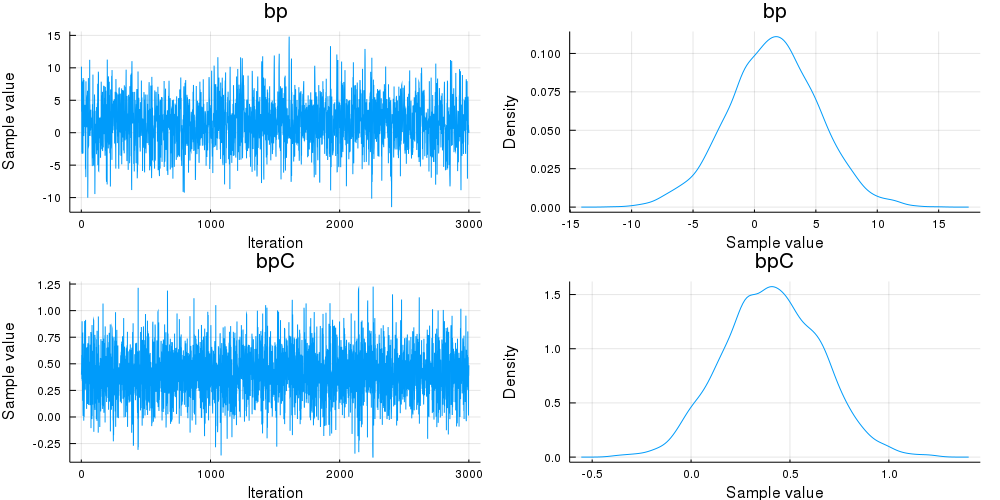

In [13]:
plot(chns)

Plot the chain pooled parameters

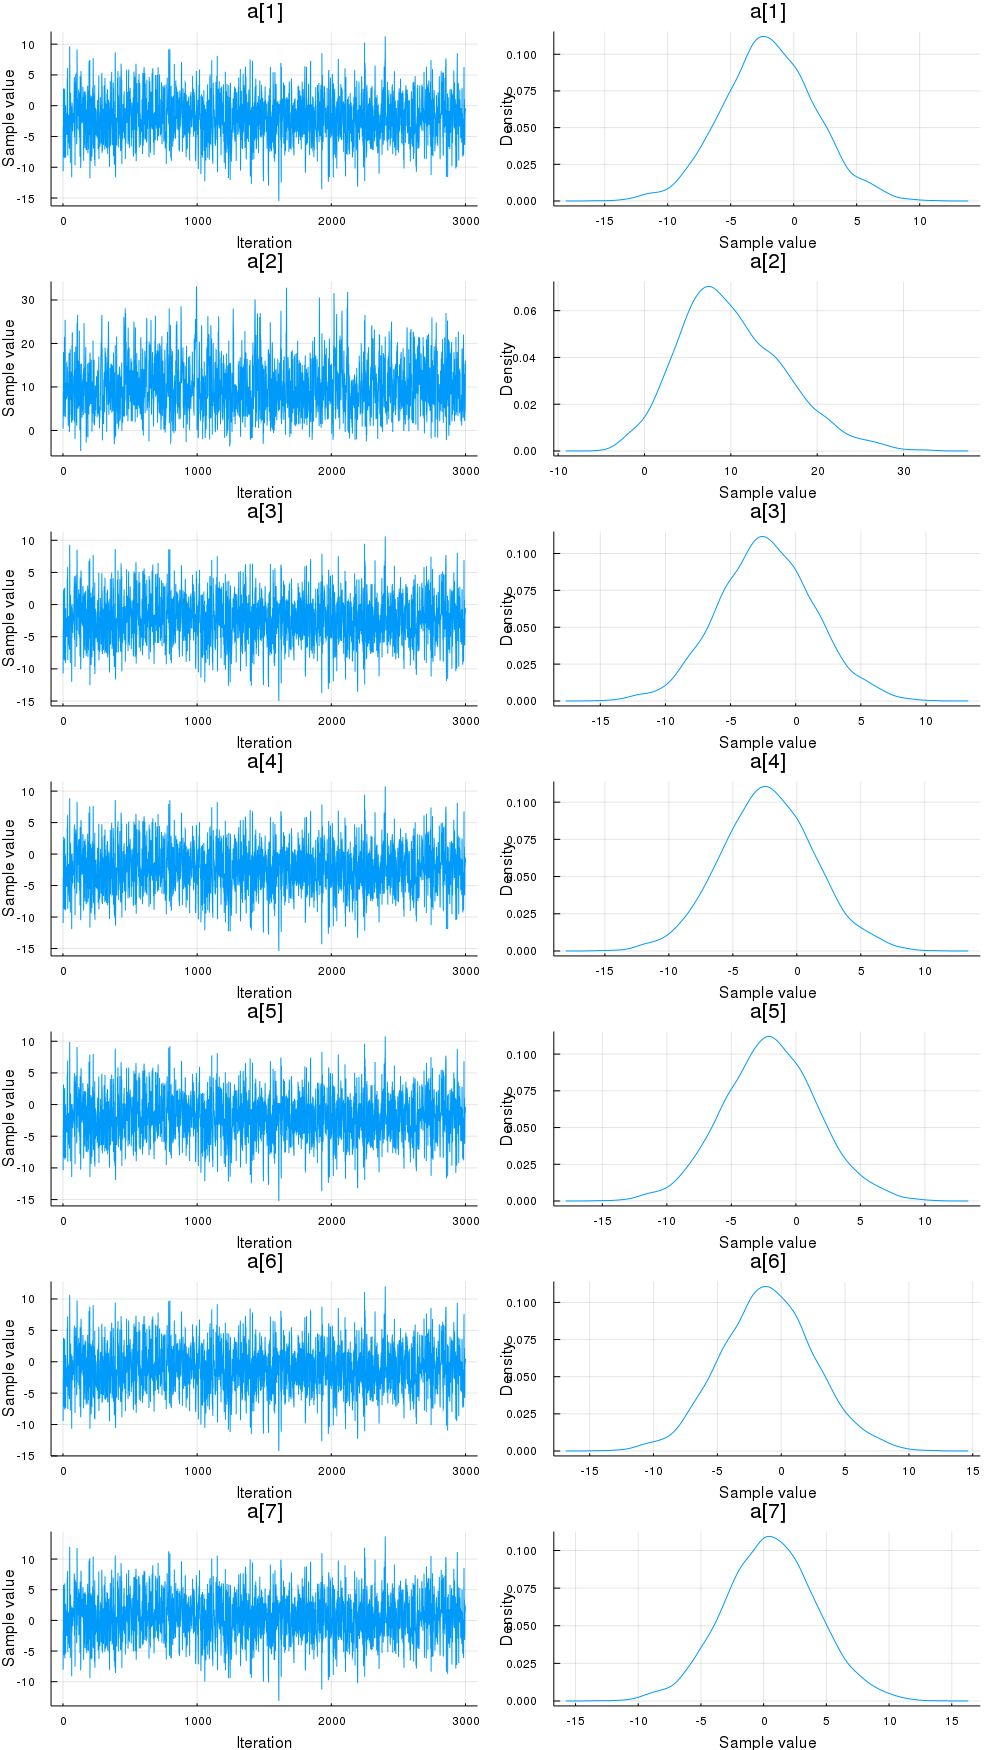

In [14]:
plot(chns, section=:pooled)

End of `m10.04d1.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*